In [5]:
import torch #PyTorchの基本ライブラリ
import torch.nn as nn #ニューラルネットワークモデルを構築するため
import torch.optim as optim #最適化アルゴリズムのライブラリ
import torch.nn.functional as F #ニューラルネットワークのレイヤーや活性化関数
from torchvision import datasets, transforms #datasetsは画像データセットを簡単に取得できる。transformsは前処理用
from torch.utils.data import DataLoader #データセットの管理とバッチ処理を行う
import matplotlib.pyplot as plt #データの可視化を行う
import torchvision #画像認識用のライブラリ

In [6]:
# 複数の画像変換処理を順番に実行するためにComposeを使用
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),# 画像を左右反転する（デフォルトでは50%の確率で反転し、データ拡張に役立つ）
    transforms.RandomCrop(32, padding=4),# 画像をランダムにクロップ（切り取り）する。サイズは32*32で、4pxの余白
    transforms.ToTensor(),# 画像をPyTorchのTensor型に変換
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 各チャネル（RGB）の画素値を正規化する。画素値を[-1, 1]の範囲にスケーリング
])

In [7]:
# CIFAR-10データセットのロード
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=4, shuffle=True, num_workers=2
)

test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=4, shuffle=False, num_workers=2
)

100%|███████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:06<00:00, 26.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


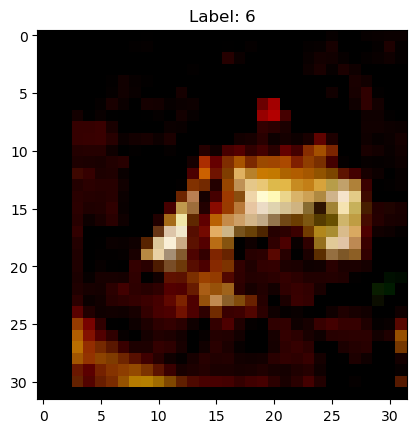

Image shape: torch.Size([3, 32, 32])
Image data type: torch.float32
Label: 6


In [8]:
# 訓練データセットから最初の画像とラベルを取得
image, label = train_set[0]

# 画像を表示
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0)) # PyTorchのテンソルはチャンネルが最初にくるので、順番を入れ替える必要がある
plt.title(f"Label: {label}")
plt.show()

# 画像データの形状とデータ型を表示
print("Image shape:", image.shape)
print("Image data type:", image.dtype)

# ラベルを表示
print("Label:", label)

In [28]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)#訓練用データセット
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)#テスト用データセット

In [10]:
classes = (
    'airplane', 'automobile', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
)


In [39]:
class CIFARClassifierImproved(nn.Module):
    def __init__(self):
        super(CIFARClassifierImproved, self).__init__()
        
        # 畳み込み層 + バッチ正規化
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        # グローバル平均プーリング
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # 全結合層
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)
        
        # ドロップアウト
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn4(self.conv4(x)))
        
        # グローバル平均プーリング
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        
        # 全結合層
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

model = CIFARClassifierImproved()



In [41]:
criterion = nn.CrossEntropyLoss()# 損失関数としてクロスエントロピー損失を使用
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)#最適化アルゴリズムとしてSGD（確率的勾配降下法）を使用


In [13]:
def train(model, train_loader, criterion, optimizer, epoch):
    model.train()#モデルを訓練モードに設定
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):#data:入力データ,target:正解ラベル
        optimizer.zero_grad()#勾配の初期化
        output = model(data)#モデルにデータを入力し、予測結果を取得
        loss = criterion(output, target)#損失を計算
        loss.backward()#誤差逆伝播法を行い、各パラメータの勾配を計算
        optimizer.step()#パラメータを更新
        running_loss += loss.item()#各ミニバッチの損失値を累積

    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')#平均損失の表示

In [22]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience#バリデーション損失が悪化しても許容する回数
        self.best_loss = None#過去のバリデーション損失を保存
        self.counter = 0#損失が悪化した回数をカウント

    def __call__(self, validation_loss):
        if self.best_loss is None:#初回の呼び出し時に
            self.best_loss = validation_loss#best_lossを設定
        elif validation_loss > self.best_loss:#バリデーション損失が悪化した場合
            self.counter += 1#カウンターを増加
            if self.counter >= self.patience:#許容範囲を越えたら終了
                print("Early stopping")
                return True
        else:
            self.best_loss = validation_loss#更新
            self.counter = 0
        return False

In [14]:
def validate(model, test_loader):
    model.eval()#モデルを評価モードに設定
    validation_loss = 0.0
    correct = 0
    with torch.no_grad():#勾配計算を無効化
        for data, target in test_loader:#ミニバッチ単位でデータとラベルを取得
            output = model(data)#予測結果を取得
            loss = criterion(output, target)#損失を計算
            validation_loss += loss.item()#各ミニバッチの損失値を累積
            pred = output.argmax(dim=1, keepdim=True)#出力スコアの中で一番大きいスコアのクラスを取得
            correct += pred.eq(target.view_as(pred)).sum().item()#予測結果と正解ラベルを比較し、一致している数を合計する

    accuracy = 100. * correct / len(test_loader.dataset)#精度の計算
    print(f'Accuracy: {accuracy:.2f}%')#精度を表示

    return validation_loss

In [43]:
early_stopping = EarlyStopping(patience=10)

for epoch in range(200):  # 最大エポック数
    train(model, train_loader, criterion, optimizer, epoch)
    validation_loss = validate(model, test_loader)
    
    # Early Stopping をチェック
    if early_stopping(validation_loss):
        break

Epoch 1, Loss: 1.564953532060394
Accuracy: 44.50%
Epoch 2, Loss: 1.1533327448703443
Accuracy: 59.88%
Epoch 3, Loss: 0.9866481220630734
Accuracy: 55.47%
Epoch 4, Loss: 0.8766872853879124
Accuracy: 65.58%
Epoch 5, Loss: 0.8023927852015971
Accuracy: 66.06%
Epoch 6, Loss: 0.7569013383534863
Accuracy: 70.99%
Epoch 7, Loss: 0.7078090217869605
Accuracy: 71.66%
Epoch 8, Loss: 0.6808688340284635
Accuracy: 70.83%
Epoch 9, Loss: 0.6430945482552813
Accuracy: 76.49%
Epoch 10, Loss: 0.6190817354585204
Accuracy: 75.37%
Epoch 11, Loss: 0.5958119753529044
Accuracy: 77.17%
Epoch 12, Loss: 0.5738219370317581
Accuracy: 77.04%
Epoch 13, Loss: 0.5480174092990359
Accuracy: 75.01%
Epoch 14, Loss: 0.5301822829429451
Accuracy: 78.83%
Epoch 15, Loss: 0.5162311578193284
Accuracy: 80.18%
Epoch 16, Loss: 0.5010960365805175
Accuracy: 79.86%
Epoch 17, Loss: 0.48995086657421666
Accuracy: 79.83%
Epoch 18, Loss: 0.4751262555799216
Accuracy: 81.02%
Epoch 19, Loss: 0.46786307488256096
Accuracy: 79.93%
Epoch 20, Loss: 0.44

In [47]:
# モデルのパラメータを保存
torch.save(model.state_dict(), 'cifar_classifier.pth')


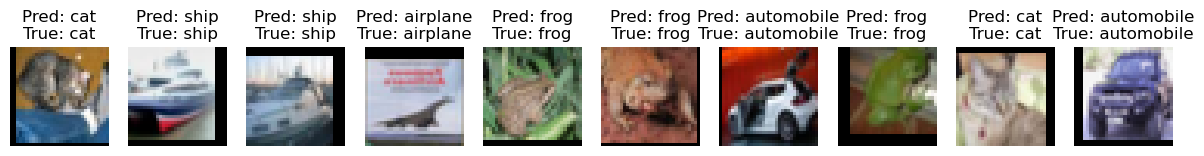

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, test_loader, classes):
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            # モデルによる予測
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True).squeeze(dim=1)

            # 画像の表示（最大10枚まで）
            num_images = min(len(data), 10)  # 最大表示数
            fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
            if num_images == 1:  # バッチサイズが1の場合
                axes = [axes]

            for i in range(num_images):
                img = data[i].numpy()
                img = np.transpose(img, (1, 2, 0))  # チャネルの順序を変換
                img = (img * 0.5 + 0.5).clip(0, 1)  # 正規化を元に戻す

                axes[i].imshow(img)
                axes[i].set_title(f"Pred: {classes[pred[i].item()]}\nTrue: {classes[target[i].item()]}")
                axes[i].axis("off")

            plt.show()
            break  # 最初のバッチのみ表示
visualize_predictions(model, test_loader, classes)


In [49]:
def calculate_accuracy(model, data_loader):
    model.eval()  # 評価モードに設定
    correct = 0
    total = 0

    with torch.no_grad():  # 勾配計算を無効化
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # 最大値のインデックスを取得
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

test_accuracy = calculate_accuracy(model, test_loader)
print(f"テストデータの正解率: {test_accuracy:.2f}%")


テストデータの正解率: 86.15%
